# First we load in the data


In [ ]:
import numpy as np    
import scipy.io as sp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


#Setting up with fluid flow data
fluid_data = sp.loadmat('cylALL.mat')

velocity_data = fluid_data['UALL']
n = int(fluid_data['n'][0][0])
m = int(fluid_data['m'][0][0])

velocity_data_reshaped = np.reshape(velocity_data, (n, m, 151), order='C').T





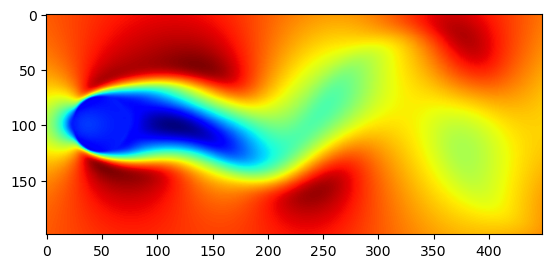

In [17]:
fig,ax = plt.subplots()
ax.imshow(velocity_data_reshaped[150,:,:],cmap='jet')

# Initialize all the SHRED stuff


In [164]:
from pyshred import DataManager, SHRED, SHREDEngine, DeviceConfig

manager = DataManager(
    lags = 12,
    train_size= 0.8,
    val_size = 0.1,
    test_size = 0.1    
)

manager.add_data(
    data = velocity_data_reshaped,
    id = 'u_velocity',
    random = 3,
    compress = False
)

train_dataset, val_dataset, test_dataset= manager.prepare()
DeviceConfig(device_type = 'cuda') # Set up device to use GPU

shred = SHRED(
    sequence_model="LSTM",
    decoder_model="MLP",
    latent_forecaster="LSTM_Forecaster"
)


# Training


In [169]:
val_errors = shred.fit(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    num_epochs=140,
    batch_size= 32,
    verbose = True,
    lr = 0.0004,
    patience = 100
)

Fitting SHRED...
Epoch 1: Average training loss = 0.345885
Validation MSE (epoch 1): 0.333856
Epoch 2: Average training loss = 0.322222
Validation MSE (epoch 2): 0.299209
Epoch 3: Average training loss = 0.279805
Validation MSE (epoch 3): 0.243433
Epoch 4: Average training loss = 0.217552
Validation MSE (epoch 4): 0.171706
Epoch 5: Average training loss = 0.149379
Validation MSE (epoch 5): 0.124712
Epoch 6: Average training loss = 0.132875
Validation MSE (epoch 6): 0.138865
Epoch 7: Average training loss = 0.132431
Validation MSE (epoch 7): 0.119609
Epoch 8: Average training loss = 0.115789
Validation MSE (epoch 8): 0.115786
Epoch 9: Average training loss = 0.116207
Validation MSE (epoch 9): 0.120010
Epoch 10: Average training loss = 0.118696
Validation MSE (epoch 10): 0.119302
Epoch 11: Average training loss = 0.116707
Validation MSE (epoch 11): 0.116727
Epoch 12: Average training loss = 0.115062
Validation MSE (epoch 12): 0.116345
Epoch 13: Average training loss = 0.115141
Validation

# Downstream tasks

In [170]:
engine = SHREDEngine(manager, shred) #Initialize the SHRED engine used for downstream tasks

# obtain latent space of test sensor measurements
test_latent_from_sensors = engine.sensor_to_latent(manager.test_sensor_measurements)

# generate latent states from validation sensor measurements
val_latents = engine.sensor_to_latent(manager.val_sensor_measurements)

# decode latent space generated from sensor measurements (generated using engine.sensor_to_latent())
test_reconstruction = engine.decode(test_latent_from_sensors)

# ---------------- Train Evaluation ----------------
t_train = len(manager.train_sensor_measurements)
train_Y = {'u_velocity': velocity_data_reshaped[0:t_train]}  # Ground truth segment
train_error = engine.evaluate(manager.train_sensor_measurements, train_Y)

# ---------------- Validation Evaluation ----------------
t_val = len(manager.val_sensor_measurements)
val_Y = {'u_velocity': velocity_data_reshaped[t_train:t_train + t_val]}
val_error = engine.evaluate(manager.val_sensor_measurements, val_Y)

# ---------------- Test Evaluation ----------------
t_test = len(manager.test_sensor_measurements)
test_Y = {'u_velocity': velocity_data_reshaped[-t_test:]}
test_error = engine.evaluate(manager.test_sensor_measurements, test_Y)

# ---------------- Print Results ----------------
print("---------- TRAIN ----------")
print(train_error)

print("\n---------- VALIDATION ----------")
print(val_error)

print("\n---------- TEST ----------")
print(test_error)

---------- TRAIN ----------
                 MSE      RMSE       MAE      R2
dataset                                         
u_velocity  0.000091  0.009556  0.006111  0.9948

---------- VALIDATION ----------
                 MSE      RMSE       MAE        R2
dataset                                           
u_velocity  0.000302  0.017389  0.009375  0.958349

---------- TEST ----------
                 MSE      RMSE       MAE        R2
dataset                                           
u_velocity  0.020939  0.144702  0.081658 -0.922124


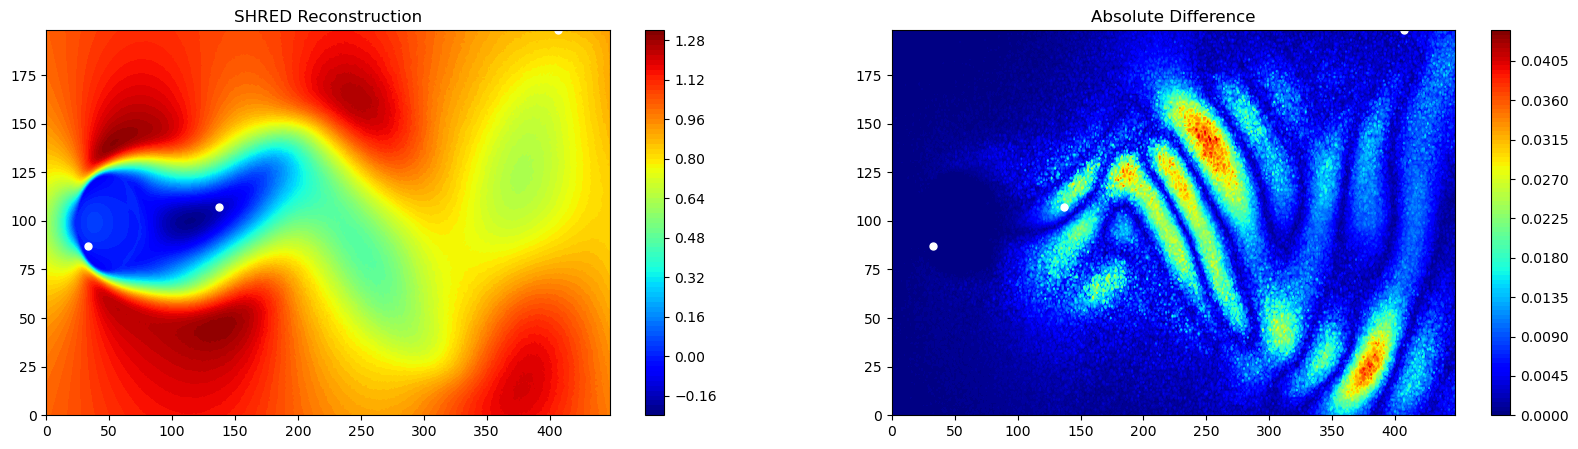

In [177]:
h = len(manager.test_sensor_measurements) # Prediction horizon

sensor_loc = manager.sensor_summary_df['loc/traj'].values
# print(f"Sensor locations (x,y): {sensor_loc}")

# The first reconstructions are not good because the meassurements are padded with zeros. So when you are far enough into the "future" to match your lags 
# you can start evaluating the reconstructions
h = len(manager.test_sensor_measurements)  # Prediction horizon
index = (-1)  # Index of the final frame in the test set (considering lags) 
# Final ground truth frame from the test set
truth = velocity_data_reshaped[index]

# Extract final reconstructed frame (from sensor-based latents)
reconstructions = test_reconstruction["u_velocity"]
reconstruction = reconstructions[index]


# Create side-by-side comparison plot
fig,ax = plt.subplots(1,2, figsize=(20,5))
cf0 = ax[0].contourf(reconstruction, levels=100, cmap='jet')
ax[0].set_title('SHRED Reconstruction')
fig.colorbar(cf0, ax=ax[0])
cf1 = ax[1].contourf(abs(truth - reconstruction), levels=100, cmap='jet')
ax[1].set_title('Absolute Difference')
fig.colorbar(cf1, ax=ax[1])  # Add colorbar to the second plot
for y,x in sensor_loc:
    ax[0].plot(x,y,markersize=5,color='white',marker='o')
    ax[1].plot(x,y,markersize=5,color='white',marker='o')
# ax.plot(x,forecast,label = 'forecast')
# ax.legend()

In [59]:
dff = (abs(truth - reconstruction)+1)/(truth+1)-1
np.max(dff)

0.3037627047729512

In [95]:
manager.sensor_summary_df['loc/traj'].values

array([(3, 247), (65, 185), (77, 78)], dtype=object)

In [146]:
print(manager.test_sensor_measurements[0:1,:])
engine.sensor_to_latent(manager.test_sensor_measurements[0:1,:]).shape
# test_reconstruction = engine.decode(test_latent_from_sensors[0,:])

[[0.873896 0.818198 1.21796 ]]


(1, 64)